# CMU ARCTIC
http://www.festvox.org/cmu_arctic/    
- 32k, 51m speech data (bdl(male), slt(female)  
- Prerequisite; Data should be downloaded  

## Define utils

In [1]:
import os
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

import torch         # >= 1.8.0
import torchaudio    # >= 0.8.0
import torchaudio.functional as F
import torchaudio.transforms as T

In [2]:
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

    
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)
    

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

    
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(ipd.Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(ipd.Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

## Data stats

### Enter data location.

In [3]:
data_dir = './TTS-DATASET/cmu_us_slt_arctic/orig'

In [4]:
files = os.listdir(data_dir)

In [5]:
# audio example
file1 = os.path.join(data_dir, files[0])
waveform, sample_rate = torchaudio.load(file1)

In [6]:
print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 32000
Shape: (2, 122880)
Dtype: torch.float32
 - Max:      0.251
 - Min:     -0.257
 - Mean:    -0.000
 - Std Dev:  0.054

tensor([[-1.0376e-03, -8.8501e-04, -8.8501e-04,  ...,  3.3569e-04,
          9.1553e-05,  1.2207e-04],
        [ 4.7607e-03,  3.9978e-03,  4.3945e-03,  ..., -4.6387e-03,
         -3.8757e-03, -6.1340e-03]])



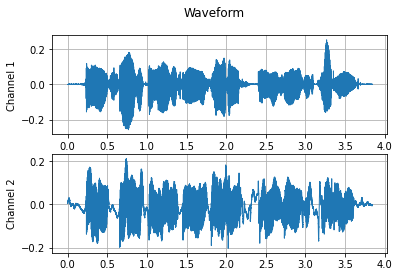

In [7]:
# channel[1] contains noise
plot_waveform(waveform, sample_rate)

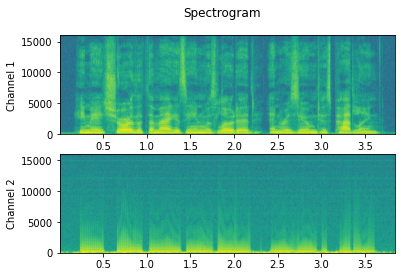

In [8]:
plot_specgram(waveform, sample_rate)

In [9]:
ipd.Audio(waveform, rate=sample_rate)

In [10]:
# channel[0] : speech
ipd.Audio(waveform[0], rate=sample_rate)

In [11]:
# channel[0] : some beep with noise
ipd.Audio(waveform[1], rate=sample_rate)

## Data manipulation
- channel 0 : speech  
- channel 1 : some speech and noise
- Processed audio would be mono, addition of channel 0, and highpassed channel 1 + gained dB

In [12]:
from tqdm import tqdm
from pathlib import Path

### Enter output directory location, samplerate for downsampling

In [13]:
out_dir = './TTS-DATASET/cmu_us_slt_arctic/processed'
Path(out_dir).mkdir(exist_ok=True, parents=True)
resample_rate = 22050

In [14]:
def preprocess(files):
    for f in tqdm(files):
        file = os.path.join(data_dir, f)
        out_file = os.path.join(out_dir, f)
        
        waveform, sample_rate = torchaudio.load(file)
        waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
        
        waveform_0 = waveform[0].unsqueeze(0)
        waveform_1 = F.lowpass_biquad(waveform[1], sample_rate, cutoff_freq=200)
        waveform_1 = waveform_1.unsqueeze(0)
        
        waveform = waveform_0 + waveform_1
        waveform = F.gain(waveform, gain_db=10.0)
        torchaudio.save(out_file, waveform, resample_rate)

In [15]:
preprocess(files)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1132/1132 [01:11<00:00, 15.91it/s]
